# 导入函数库

In [1]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.tsa.stattools as ts


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

# 定义自定义函数

In [2]:
# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    
    # 第一个参数为beta，第二个参数为alpha
    return state_means[-1]



# 进行画图，判断AR、MA的延迟阶数

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]

# 策略研究

策略：求出差分后的残差$\epsilon$

1. 确定kalman方程的beta、alpha
2. 确定相应的$\epsilon$
3. 求出$\epsilon$的差分值
4. 求出差分值的平均值、方差值
5. 价格推导公式如下：

t-1 时刻：$Q_{t-1} = \beta * P_{t-1} + \alpha + \epsilon_{t-1}$

t时刻：$Q_{t} = \beta * P_{t} + \alpha + \epsilon_{t}$

做处理，将t时刻的等式减去t-1时刻的等式，汇总后

$Q_{t} - Q_{t-1} = \beta * P_{t} + \alpha + \epsilon_{t} - \beta * P_{t-1} - \alpha - \epsilon_{t-1}$


$\epsilon_{t} - \epsilon_{t-1} = (Q_{t} - Q_{t-1}) - \beta * (P_{t} - P_{t-1})$

$Q_{t}$是因变量，$P_{t}$是自变量，t-1时刻的值为已观察到的值，$（\epsilon_{t} - \epsilon_{t-1}）$是随机变量，均值方差根据历史数据求出，根据上式可以得出：

$Q_{t} = (\epsilon_{t} - \epsilon_{t-1}) + \beta * (P_{t} - P_{t-1}) + Q_{t-1}$


结论：

$Q_{t}$是推导出来的值，$\epsilon_{t} - \epsilon_{t-1}$是随机变量（0均值），$\beta$是历史推导值，其他是观察值，所以如果观察到$Q_{t}$价格偏差较大，就可以推导出应该的价格

# 策略推导

策略：求出差分后的残差$\epsilon$

1. 确定kalman方程的beta、alpha
2. 确定相应的$\epsilon$
3. 求出$\epsilon$的差分值
4. 求出差分值的平均值、方差值
5. 价格推导公式如下：

t-1 时刻：$Q_{t-1} = \beta * P_{t-1} + \alpha + \epsilon_{t-1}$

t时刻：$Q_{t} = \beta * P_{t} + \alpha + \epsilon_{t}$

做处理，将t时刻的等式减去t-1时刻的等式，汇总后

$Q_{t} - Q_{t-1} = \beta * P_{t} + \alpha + \epsilon_{t} - \beta * P_{t-1} - \alpha - \epsilon_{t-1}$


$\epsilon_{t} - \epsilon_{t-1} = (Q_{t} - Q_{t-1}) - \beta * (P_{t} - P_{t-1})$



# 策略实现


如果$\epsilon_{t} - \epsilon_{t-1}$位于底部区间，则意味着

$(Q_{t+1} - Q_{t}) - \beta * (P_{t+1} - P_{t})$ 上升

意味着：
$(Q_{t+1} - Q_{t})$上升，或者$\beta * (P_{t+1} - P_{t})$下降

对于时刻：
- t-1时刻：仅作为参考运算
- t  时刻：开始计算$\epsilon_{t} - \epsilon_{t-1}$，如果正常范围，不做处理，如果超出范围则开始监测，因为$\epsilon_{t} - \epsilon_{t-1}$会回归到0
- t+1时刻：正处在回归过程中，回归到途径，要么$(Q_{t+1} - Q_{t})$上升，或者$\beta * (P_{t+1} - P_{t})$下降

按照以上说明，可以推导出：

1. 如果下式未变化未变化：
$$\frac{P_{t+1} - P_{t}}{P_{t} - P_{t-1}}>= 1$$ 
2. 则可以确定下式会上升：
$$\frac{Q_{t+1} - Q_{t}}{Q_{t} - Q_{t-1}}$$


# 买卖信号

买入信号，同时满足：
$$\epsilon_{t+1} - \epsilon_{t} 处于区间外低点$$

$$\frac{P_{t+1} - P_{t}}{P_{t} - P_{t-1}}>1 未变小$$ 

$$\frac{Q_{t+1} - Q_{t}}{Q_{t+1} - Q_{t}}<1 未变大$$


卖出信号：
$$\epsilon_{t+1} - \epsilon_{t} 处于高位$$




In [3]:
# 生成持仓序列
# 输入：
# buy_list:[0,....,1,0,...]
# sell_list:[0,...-1,0,-1....]
# 相互融合后生成持仓序列：[0,0,....1,0,1,....]

def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new

    return np.cumsum(combine_list_new)

## 回测数列处理

1. 确定买入点、卖出点数列
2. 整理数列，确定三个状态：
    - 0：与前面状态一致的状态，可以称为稳定状态
    - 1：买入状态：将现在的状态改变为买入状态
    - -1：卖出状态，将现在的状态改变为卖出状态
3. 确定一个状态变更列表
4. 对状态变更列表进行处理，处理原则：一开始设置为卖出状态；若为0，则与前状态一致；若为1，则变更为买入状态；若为-1 则变更为卖状态；如果状态已经是当前要变更的状态，则不作处理
5. 对状态变更列表进行差分，异或处理，确定状态跳变的时间点
6. 以状态跳变时间点的列表与买入点、卖出点数列进行并运算，得出新的买入点、卖出点数列
7. 以新的买入点、卖出点数列作为新的序列
8. 已新的序列（三状态：0，+1，-1）计算cucum()，计算仓位结果


示例：

|类别|第1天|第2天|第3天|第4天|第5天|第6天|第7天|第8天|第9天|第10天|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|1.买入点|0|1|0|0|0|0|0|1|0|0|
|2.卖出点|0|0|0|-1|0|0|-1|0|-1|0|
|3.混合序列|0|1|0|-1|0|0|-1|1|-1|0|
|4.状态序列|-1|1|1|-1|-1|-1|-1|1|-1|-1|
|5.状态差分|-1|-1|1|1|-1|-1|-1|-1|1|-1|
|6.状态异或|0|1|0|1|0|0|0|1|1|0|
|7.买入并|0|1|0|0|0|0|0|1|0|0|
|8.卖出并|0|0|0|-1|0|0|0|0|-1|0|
|9.新混合|0|1|0|-1|0|0|0|1|-1|0|
|10.累加运算|0|1|1|0|0|0|0|1|0|0|

最终使用10#序列与收益率相乘，得到最后收益率曲线，最终来画图

# 开始验证

In [4]:
# 求出两只股票
end_date = '2018-9-30'
ncount = 500



sec1 = '601939.XSHG'
sec2 = '601288.XSHG'

sec1 = '600000.XSHG'

sec2 = '601939.XSHG'



# # 美的集团
# sec1 = '000333.XSHE'

# # 格力电器
# sec2 = '000651.XSHE'

# P，自变量
S1 = get_price(sec1, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# Q，因变量
S2 = get_price(sec2, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
beta_kf = kalman_beta(S1,S2)
beta = kalman_beta(S1,S2)[0]
alpha = kalman_beta(S1,S2)[1]

In [5]:
# 求出基本参数
res = S2 - np.dot(sm.add_constant(S1, prepend=False), beta_kf)

res_diff = res - res.shift(1)
res_diff = res_diff.fillna(0)


std_deviation = np.std(res_diff)
mean = np.mean(res_diff)

In [6]:
# 基本参数验证
Cadf_test(res_diff)

0.0

H0：there is unit root

因为概率低于0.05，所以可以推翻H0

结论：不存在Unit Root，是平稳序列

In [7]:
# 基本参数验证
test_stochastic(res_diff)

0.10101467316544802

H0：原本的数据都是纯随机序列

因为概率低于0.05，所以可以推翻H0

结论就是序列是非纯随机序列

In [8]:
beta

0.60208055956148743

In [9]:
alpha

0.41144041499425538

In [10]:
std_deviation

0.09513057468114867

In [11]:
# 开始进行验证

start_date = '2018-10-1'
end_date = '2019-2-28'

# 美的集团,P
S1_validation = get_price(sec1, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 格力电器,Q
S2_validation = get_price(sec2, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

P_index = get_price('000300.XSHG', start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


# 策略实现

step1：

确定$Q_{t+1}$，$Q_{t}$，$Q_{t-1}$，$P_{t}$，$P_{t-1}$，$P_{t+1}$

step2：

在t-1时刻，观察$\epsilon_{t-1}$


step3：


在t时刻，确定$\epsilon_{t} - \epsilon_{t-1}$ 是否达到下界

如果达到下界则确定操作变量，表示可以进行买入交易


step4：

观察$Q_{t+1}$，$P_{t+1}$

判断：
1. $$\frac{P_{t+1} - P_{t}}{P_{t} - P_{t-1}}>1 未变小$$ 



2. $$\frac{Q_{t+1} - Q_{t}}{Q_{t} - Q_{t-1}}<1 未变大$$

同时满足则买入

step5：

当前为t+1时刻，同时观测，如果当前观察到$\epsilon_{t+1} -\epsilon_{t}$，则卖出

**说明：模拟为了方便，均采用收盘价作为模拟，在实际模拟中可以采用当前分钟级数据与前两天的日线数据对比**

In [12]:
# 生成买入信号序列

buy_point = []

# t-1时刻、t时刻buy_point为0
buy_point.append(0)
buy_point.append(0)

# 当前在t+1时刻，需要回溯到t-1时刻
for t in range(2,S1_validation.shape[0]):
    # step1：确定时间点价格
    # 确定3个时间点的价格
    P0 = S1_validation[t-2]
    P1 = S1_validation[t-1]
    P2 = S1_validation[t]
    
    Q0 = S2_validation[t-2]
    Q1 = S2_validation[t-1]
    Q2 = S2_validation[t]    

    # 设置买入信号
    if_buy = False
    
    # step2：计算t-1时刻残差，t时刻残差
    res_0 = Q0 - beta * P0 - alpha
    res_1 = Q1 - beta * P1 - alpha

    # step3：看计算的t时刻残差是否达到标准
    res_diff_1 = res_1 - res_0
    
    if res_diff_1 < -std_deviation*0.5:
        # 设置买入信号为真
        if_buy = True

    # step4：观察价格是否变化
    if if_buy:
        # P价格变化比例
        Delta_P = (P2 - P1)/(P1 - P0)
        # Q价格变化比例
        Delta_Q = (Q2 - Q1)/(Q1 - Q0)
        
        if (Delta_P >= 1) and (Delta_Q <= 1):
            buy_point.append(1)
        else:
            buy_point.append(0)

    else:
        #不能进行买入
        buy_point.append(0)

In [13]:
# 买入点总数
sum(buy_point)

4

In [14]:
# 生成卖出信号序列
sell_point = []
# 当前为t时刻，与买入信号不同
# 只需要往前追溯1天
sell_point.append(0)

# 当前在t+1时刻，需要回溯到t-1时刻
for t in range(1,S1_validation.shape[0]):
    
    # step1：确定时间点价格
    # 确定2个时间点的价格
    P0 = S1_validation[t-1]
    P1 = S1_validation[t]
    
    Q0 = S2_validation[t-1]
    Q1 = S2_validation[t]  
    
    # step2：计算t-1时刻残差，t时刻残差
    res_0 = Q0 - beta * P0 - alpha
    res_1 = Q1 - beta * P1 - alpha

    # step3：看计算的t时刻残差是否达到标准
    res_diff_1 = res_1 - res_0
    
    if res_diff_1 > 0:   #可选参数std_deviation
        # 设置卖出信号
        sell_point.append(-1)
    else:
        sell_point.append(0)



In [15]:
# 卖出点总数
sum(sell_point)

-43

In [16]:
# 生成持仓序列
hold_list = position_generate(buy_point,sell_point)

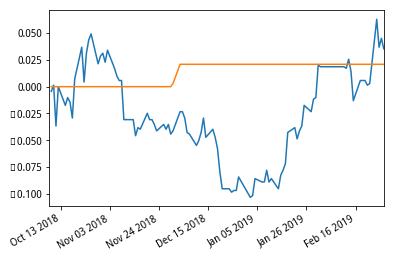

In [17]:
S2_Yield = np.cumsum(np.log(S2_validation) - np.log(S2_validation.shift(1)) )
pd.Series(S2_Yield*np.ones(len(S2_Yield))).plot()



# np.cumsum(((np.log(P_index) - np.log(P_index.shift(1)) )*hold_list)).plot()
# np.cumsum().plot()


np.cumsum(((np.log(S2_validation) - np.log(S2_validation.shift(1)) )*hold_list)).plot()

# np.cumsum(((np.log(S2_validation) - np.log(S2_validation.shift(1)) )*hold_list) - ((np.log(P_index) - np.log(P_index.shift(1)) )*hold_list)).plot()

# 找到买入点，卖出点对应的下标

In [21]:
# np.where能够返回等于1的所有的下标
print np.where(np.array(buy_point) == 1)

# list.index 只能够返回最近的一个下标
print buy_point.index(1)

(array([ 6, 21, 39, 69]),)
6


In [22]:
np.where(np.array(hold_list) == 1)

(array([39, 40, 41]),)

In [23]:
# 找到对应的交易时间，在回测中进行验证

S1_validation.index[list(np.where(np.array(hold_list) == 1))]

DatetimeIndex(['2018-11-30', '2018-12-03', '2018-12-04'], dtype='datetime64[ns]', freq=None, tz=None)

以下的内容是与回测的结果进行验证

找到11月30日当天的所有数据进行对比

In [24]:
S1_validation[S1_validation.index == '2018-11-30']

2018-11-30    10.71
Name: close, dtype: float64

In [25]:
P2 = S1_validation[S1_validation.index == '2018-11-30'].values[0]
P1 = S1_validation[S1_validation.index == '2018-11-29'].values[0]
P0 = S1_validation[S1_validation.index == '2018-11-28'].values[0]

In [26]:
print P0,P1,P2

10.58 10.63 10.71


In [27]:
Q2 = S2_validation[S2_validation.index == '2018-11-30'].values[0]
Q1 = S2_validation[S2_validation.index == '2018-11-29'].values[0]
Q0 = S2_validation[S2_validation.index == '2018-11-28'].values[0]

In [28]:
print Q0,Q1,Q2

6.69 6.63 6.65


In [29]:
print std_deviation

0.0951305746811


In [31]:
# 第1天的残差变化情况，用来判断是否满足交易条件
print (Q1 - beta * P1 - alpha) - (Q0 - beta * P0 - alpha)


-0.0901040279781


# 简化买入信号

In [1]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.tsa.stattools as ts


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

In [2]:
# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    
    # 第一个参数为beta，第二个参数为alpha
    return state_means[-1]



# 进行画图，判断AR、MA的延迟阶数

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]

In [3]:
# 生成持仓序列
# 输入：
# buy_list:[0,....,1,0,...]
# sell_list:[0,...-1,0,-1....]
# 相互融合后生成持仓序列：[0,0,....1,0,1,....]

def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new

    return np.cumsum(combine_list_new)

In [4]:
# 求出两只股票
end_date = '2018-9-30'
ncount = 500



sec1 = '601939.XSHG'
sec2 = '601288.XSHG'

sec1 = '600000.XSHG'

sec2 = '601939.XSHG'



# # 美的集团
# sec1 = '000333.XSHE'

# # 格力电器
# sec2 = '000651.XSHE'

# P，自变量
S1 = get_price(sec1, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# Q，因变量
S2 = get_price(sec2, count =  ncount, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


# 计算alpha、beta
# 按照定义：S1为自变量，S2为因变量
beta_kf = kalman_beta(S1,S2)
beta = kalman_beta(S1,S2)[0]
alpha = kalman_beta(S1,S2)[1]

In [5]:
# 求出基本参数
res = S2 - np.dot(sm.add_constant(S1, prepend=False), beta_kf)

res_diff = res - res.shift(1)
res_diff = res_diff.fillna(0)


std_deviation = np.std(res_diff)
mean = np.mean(res_diff)

In [6]:
# 开始进行验证

start_date = '2018-10-1'
end_date = '2019-2-28'

# 美的集团,P
S1_validation = get_price(sec1, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

# 格力电器,Q
S2_validation = get_price(sec2, start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']

P_index = get_price('000300.XSHG', start_date =  start_date, end_date= end_date, frequency='1d', fields='close',fq = "pre")['close']


In [11]:
# 生成买入信号序列

buy_point = []

# t-1时刻、t时刻buy_point为0
buy_point.append(0)
buy_point.append(0)

# 当前在t+1时刻，需要回溯到t-1时刻
for t in range(2,S1_validation.shape[0]):
    # step1：确定时间点价格
    # 确定3个时间点的价格
    P0 = S1_validation[t-2]
    P1 = S1_validation[t-1]
    P2 = S1_validation[t]
    
    Q0 = S2_validation[t-2]
    Q1 = S2_validation[t-1]
    Q2 = S2_validation[t]    

    # 设置买入信号
    if_buy = False
    
    # step2：计算t-1时刻残差，t时刻残差
    res_0 = Q0 - beta * P0 - alpha
    res_1 = Q1 - beta * P1 - alpha

    # step3：看计算的t时刻残差是否达到标准
    res_diff_1 = res_1 - res_0
    
    if res_diff_1 < -std_deviation*0.5:
        # 设置买入信号为真
        if_buy = True

    # step4：观察价格是否变化
    if if_buy:
        buy_point.append(1)

    else:
        #不能进行买入
        buy_point.append(0)

In [12]:
# 生成卖出信号序列
sell_point = []
# 当前为t时刻，与买入信号不同
# 只需要往前追溯1天
sell_point.append(0)

# 当前在t+1时刻，需要回溯到t-1时刻
for t in range(1,S1_validation.shape[0]):
    
    # step1：确定时间点价格
    # 确定2个时间点的价格
    P0 = S1_validation[t-1]
    P1 = S1_validation[t]
    
    Q0 = S2_validation[t-1]
    Q1 = S2_validation[t]  
    
    # step2：计算t-1时刻残差，t时刻残差
    res_0 = Q0 - beta * P0 - alpha
    res_1 = Q1 - beta * P1 - alpha

    # step3：看计算的t时刻残差是否达到标准
    res_diff_1 = res_1 - res_0
    
    if res_diff_1 > 0:   #可选参数std_deviation
        # 设置卖出信号
        sell_point.append(-1)
    else:
        sell_point.append(0)



In [13]:
# 生成持仓序列
hold_list = position_generate(buy_point,sell_point)

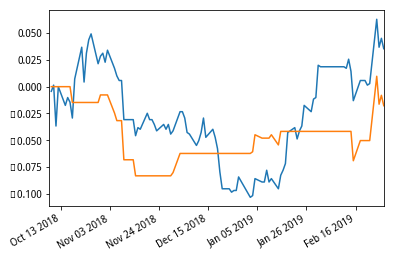

In [14]:
S2_Yield = np.cumsum(np.log(S2_validation) - np.log(S2_validation.shift(1)) )
pd.Series(S2_Yield*np.ones(len(S2_Yield))).plot()



# np.cumsum(((np.log(P_index) - np.log(P_index.shift(1)) )*hold_list)).plot()
# np.cumsum().plot()


np.cumsum(((np.log(S2_validation) - np.log(S2_validation.shift(1)) )*hold_list)).plot()